In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [3]:
import numpy as np
import torch
import matplotlib
from matplotlib import pyplot as plt
import random
import json
import sys
sys.path.insert(0,'/home/brysongray/tractography/')
import dqn_tracker
import tracking_env
import train_dqn_tracker
from load_data import load_data
from tracking_env import Environment, density_error_change
from dqn_tracker import DQNModel
import os
from itertools import count
from tqdm import tqdm
from image import Image
from skimage.filters import gaussian
from IPython.display import display, clear_output

In [3]:
def show_state(env, z=None, finished=False, path_id=0, t=-1):
    
    if finished:
        paths = env.finished_paths
    else:
        paths = env.paths
        path_id = env.head_id

    state, _ = env.img.crop(paths[path_id][t], env.radius, pad=True, value=0.0)
    state = state.detach().clone()
    true_density_patch, _ = env.true_density.crop(paths[path_id][t], env.radius, pad=True)
    bundle_density_patch, _ = env.bundle_density.crop(paths[path_id][t], env.radius, pad=True)
    mask = Image(env.mask)
    mask_patch, _ = mask.crop(paths[path_id][t], env.radius, interp=False, pad=True)
    I = np.array(env.img.data.to('cpu'))
    D = np.array(env.true_density.data.to('cpu'))
    O = np.array(state.to('cpu'))
    T = np.array(true_density_patch.to('cpu'))
    B = np.array(bundle_density_patch.to('cpu'))
    M = np.array(mask_patch.to('cpu'))
    if z is not None:
        z_ = state.shape[2]//2
        I = I[:, z]
        D = D[0,z]
        O = O[:, z_]
        T = T[0,z_]
        B = B[0,z_]
        M = M[0,z_]
    else: # project along z
        I = I.max(axis=1)
        D = D[0].max(axis=0)
        O = O.max(axis=1)
        T = T[0].max(axis=0)
        B = B[0].max(axis=0)
        M = M[0].max(axis=0)
    plt.cla()
    fig, ax = plt.subplots(1,3)
    ax[0].imshow(I[-1], cmap='hot', alpha=0.5) #, int(paths[env.head_id][-1, 0])])
    ax[0].imshow(I[:3].transpose(1,2,0), alpha=0.5) #, int(paths[env.head_id][-1, 0])])
    ax[0].axis('off')
    ax[1].imshow(O[:3].transpose(1,2,0), alpha=0.75)
    ax[1].imshow(O[-1], alpha=0.25, cmap='hot') #, env.radius//2])
    ax[1].axis('off')
    toshow = np.stack((B, T, M), axis=-1)
    ax[2].imshow(toshow)
    ax[2].axis('off')

    display(fig)

def get_closest_dir(action_space, dir):
    d = np.dot(action_space, dir[:,None])
    idx = d.argmax()

    return idx

In [4]:
f = open('/home/brysongray/tractography/neuron_trx/configs/config.json')
args = json.load(f)

img_file = args["image"]
label_file = args["label"]
seeds = args["seeds"]
model = args["model"] if "model" in args else None
n_seeds = args["n_seeds"] if "n_seeds" in args else 1
step_size = args["step_size"] if "step_size" in args else 1.0
step_width = args["step_width"] if "step_width" in args else 1.0
batch_size = args["batchsize"] if "batchsize" in args else 128
gamma = args["gamma"] if "gamma" in args else 0.99
eps_start = args["eps_start"] if "eps_start" in args else 0.9
eps_end = args["eps_end"] if "eps_end" in args else 0.01
eps_decay = args["eps_decay"] if "eps_decay" in args else 1000
tau = args["tau"] if "tau" in args else 0.001
lr = args["lr"] if "lr" in args else 5e-4
alpha = args["alpha"] if "alpha" in args else 1.0
beta = args["beta"] if "beta" in args else 1e-3
friction = args["friction"] if "friction" in args else 1e-4
num_episodes = args["num_episodes"] if "num_episodes" in args else 100
pixelsize = args["pixelsize"] if "pixelsize" in args else [1.0, 1.0, 1.0]
patch_radius = 17
actions = np.load('/home/brysongray/tractography/neuron_trx/action_space_30_dir.npy')

img, density, mask = load_data(img_file, label_file, pixelsize=pixelsize, inverse=True)

env = Environment(img,
                patch_radius,
                seeds,
                mask,
                density,
                actions,
                n_seeds=n_seeds,
                step_size=step_size,
                step_width=step_width,
                max_len=10000,
                alpha=alpha,
                beta=beta,
                friction=friction)

dqn_model = DQNModel(in_channels=4,
                    n_actions=len(actions),
                    input_size=(2*patch_radius+1),
                    lr=lr,
                    step_size=torch.tensor(step_size))

if model:
    dqn_model.load_model(torch.load(model))


/home/brysongray/tractography/data/Cerebellar Climbing Fibers/Gold Standard Reconstructions/CF_1.swc:1506:warning

/home/brysongray/tractography/data/Cerebellar Climbing Fibers/Gold Standard Reconstructions/CF_1.swc:1493:warning

/home/brysongray/tractography/data/Cerebellar Climbing Fibers/Gold Standard Reconstructions/CF_1.swc:1322:warning

/home/brysongray/tractography/data/Cerebellar Climbing Fibers/Gold Standard Reconstructions/CF_1.swc:1216:warning

/home/brysongray/tractography/data/Cerebellar Climbing Fibers/Gold Standard Reconstructions/CF_1.swc:1118:warning

/home/brysongray/tractography/data/Cerebellar Climbing Fibers/Gold Standard Reconstructions/CF_1.swc:0:warning


In [ ]:
dqn_model.train(env,
                episodes=num_episodes,
                batch_size=batch_size,
                gamma=gamma,
                tau=tau,
                eps_start=eps_start,
                eps_end=eps_end,
                eps_decay=eps_decay,
                save_snapshots=True,
                show=True,
                output="/home/brysongray/tractography/outputs_test",
                name='test')

## view mask and density

In [ ]:
# z=19
fig, ax = plt.subplots(1,3)
ax[0].imshow(env.img.data[:3].permute(1,2,3,0).amax(dim=0), alpha=1.0)
ax[1].imshow(env.true_density.data[0].amax(dim=0), alpha=1.0, cmap='hot')
ax[2].imshow(env.mask.data[0].amax(dim=0))

### Choose seed points for testing

In [5]:
test_seeds = [[20, 280, 588],
              [24, 305, 250],
              [25, 472, 372],
              [27, 345, 462],
              [14, 60, 379],
              [19, 160, 542]]

In [ ]:
plt.close('all')

In [ ]:
z = 19
fig, ax = plt.subplots(1,2)
I = env.img.data[:3].permute(1,2,3,0)
T = env.true_density.data[0,z]
ax[0].imshow(T)
ax[1].imshow(I[z])

## Test crop  and draw_line_segment functions

In [ ]:
env.img.data.shape

In [ ]:
env.paths[0].shape

In [ ]:
# c = env.paths[0][-1]
c = torch.tensor([19, 0.0, 350.0])
b = torch.tensor([0,0.0,0.0])
print(c+b)
r = 4
I = env.img.crop(center=c+b, radius=r, interp=True)[0][:3]
plt.figure()
plt.imshow(I[:, r].permute(1,2,0))


In [ ]:
theta = -np.pi/4
v = torch.tensor([0.,-np.sin(theta),np.cos(theta)]) * 4.0
segment = torch.stack(((c), (c+v)))
print(segment)
# env.img.draw_line_segment(segment, width=0.0)
path = env.img.crop((c), r, interp=True)[0][-1,r]
plt.figure()
plt.imshow(path)

## Test Reward Function

In [ ]:
DEVICE = 'cuda:0'

In [ ]:
env.reset()

In [ ]:
plt.close('all')

In [ ]:
print(env.paths[env.head_id][-1])
# z = int(np.round(env.paths[env.head_id][-1,0]))
show_state(env)#, z=z)

In [ ]:
plt.close('all')

In [ ]:
env.paths[0]

In [ ]:
bending_energy = []
bending_energy_ = []
segments_ = []
energy_ = []
for i in range(len(env.paths)):
    p0 = env.paths[i][:-1]
    p1 = env.paths[i][1:]
    segments = (p1 - p0) / env.step_size
    segments_.append(segments)
    energy = (torch.einsum('ij,ij->i', segments[1:], segments[:-1]) - 1.0) / -2.0
    energy_.append(energy)
    bending_energy_.append(torch.sum(energy))
bending_energy.append(torch.sum(torch.tensor(bending_energy_)))

In [ ]:
print(segments_)

In [ ]:
print(energy_)

In [ ]:
plt.close('all')

dir_dict = {'a':torch.tensor([0., 0.0, -1.0]),
            'd':torch.tensor([0., 0.0, 1.0]),
            'w':torch.tensor([0., -1.0, 0.0]),
            's':torch.tensor([0., 1.0, 0.0]),
            }
plt.ioff()
while True:
    dir = input()
    if dir == 'q':
        break
    clear_output(True)
    observation, reward, terminated = env.step(dir_dict[dir], verbose=True)
    print(reward)
    if not terminated:
        z = int(np.round(env.paths[env.head_id][-1,0]))
        show_state(env, z)
    else:
        env.reset()

In [ ]:
# get the index of action_space closest to a desired step direction
action_id = get_closest_dir(env.action_space, torch.Tensor([0., 0., -1.]))
print(action_id)
print(env.action_space[action_id])

In [ ]:
output='./outputs'
episodes = 128


In [ ]:
# Train the Network
steps_done = 0
episode_durations = []
episode_returns = []
if not os.path.exists(output):
    os.makedirs(output)
# for i in tqdm(range(episodes)):
while len(dqn_model.memory) < batch_size:
    env.reset()
    state = env.get_state()[0].clone().to(dtype=torch.float32, device=DEVICE)
    ep_return = 0
    for t in count():
        action_id = dqn_model.select_action(env.action_space, state, steps_done, eps_start, eps_end, eps_decay)
        # observation, reward, terminated = env.step(env.action_space[action_id])
        action = env.action_space[action_id]

        # step
        terminated = False

        # add new position to path
        while True:
            new_position = env.paths[env.head_id][-1] + env.step_size*action
            out_of_bound = any([x >= y or x < 0 for x,y in zip(torch.round(new_position), env.img.data.shape[1:])])
            if out_of_bound:
                action = env.action_space[int(np.random.randint(len(env.action_space)))]
            else:
                break

        env.paths[env.head_id] = torch.cat((env.paths[env.head_id], new_position[None]))
        # decide if path terminates
        # out_of_mask = env.mask[tuple([int(x) for x in env.paths[env.head_id][-1]])]
        too_long = len(env.paths[env.head_id]) > env.max_len
        self_terminate = not any(action)
        terminate_path = too_long or self_terminate

        if terminate_path:
            observation = None
            reward = torch.tensor([0.], device=DEVICE)
            # remove the path from 'paths' and add it to 'ended_paths'
            env.ended_paths.append(env.paths.pop(env.head_id))
            # if that was the last path in the list, then terminate the episode
            if len(env.paths) == 0:
                terminated = True
            else:
                env.head_id = (env.head_id + 1)%len(env.paths)
        else:
            center = env.paths[env.head_id][-2]
            r = env.radius + int(np.ceil(env.step_size.max()))
            true_density_patch, _ = env.true_density.crop(center, radius=r) # patch centered at previous step position
            old_density_patch, _ = env.img.crop(center, radius=r)
            old_density_patch = old_density_patch.detach().clone()[-1][None] # need to make a copy or else this will be modified by adding a point to img
            # add_bundle_point(env.img, env.paths[env.head_id][-1], env.ball)
            segment = env.paths[env.head_id][-2:, :3]
            env.img.draw_line_segment(segment, width=1.0)
            new_density_patch, _ = env.img.crop(center, radius=r)
            new_density_patch = new_density_patch[-1][None]
            delta_density_diff = density_error_change(true_density_patch, old_density_patch, new_density_patch)
            observation = env.get_state()
            reward = env.get_reward(terminated, delta_density_diff)

            env.head_id = (env.head_id + 1)%len(env.paths)
        # end step
            
        ep_return += reward

        if terminated: # episode terminated
            next_state = None
        else:
            next_state = observation # if the streamline terminated observation is None
            if next_state is not None:
                next_state = next_state[0].clone().to(dtype=torch.float32, device=DEVICE)

        # Store the transition in memory
        dqn_model.memory.push(state, action_id, next_state, reward)

        # Perform one step of the optimization (on the policy network)
        dqn_model.optimize_model(batch_size, gamma)

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = dqn_model.target_net.state_dict()
        policy_net_state_dict = dqn_model.policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*tau + target_net_state_dict[key]*(1-tau)
        dqn_model.target_net.load_state_dict(target_net_state_dict)

        if terminated:
            episode_durations.append(t + 1)
            episode_returns.append(ep_return)
            # if show:
            #     plot_durations(episode_durations)
            #     plot_returns(episode_returns)
            # if save_snapshots:
            #     if i%10 == 0:
            #         torch.save(env.img.data[-1].detach().clone(), os.path.join(output, f'bundle_density_ep{i}.pt'))
            #         torch.save(target_net_state_dict, os.path.join(output, f'model_state_dict_{name}.pt'))
            #         torch.save(episode_durations, os.path.join(output, 'episode_durations_{name}.pt'))
            #         torch.save(episode_returns, os.path.join(output, 'episode_returns_{name}.pt'))
            break
        # if not terminated, move to the next state
        state = env.get_state()[0].to(dtype=torch.float32, device=DEVICE) # the head of the next streamline

In [ ]:
show_state(env)

In [ ]:
dqn_model.policy_net.state_dict()['conv1.bias'].ne(dqn_model.target_net.state_dict()['conv1.bias']).sum()

In [ ]:
# Perform one step of the optimization (on the policy network)
dqn_model_params = dqn_model.policy_net.parameters().detach().clone()
print(dqn_model.policy_net.state_dict()['conv1.bias'])
dqn_model.optimize_model(batch_size, gamma)
print(dqn_model.policy_net.state_dict()['conv1.bias'])
dqn_model_params_after = dqn_model.policy_net.parameters()

for p1, p2 in zip(dqn_model_params, dqn_model_params_after):
    if p1.data.ne(p2.data).sum() > 0:
        print("Not equal")
    else:
        print('Equal')

In [ ]:
dqn_model.policy_net.state_dict()['conv1.bias']

In [ ]:
dqn_model_params_after['conv1.bias']

In [ ]:
# Soft update of the target network's weights
# θ′ ← τ θ + (1 −τ )θ′
target_net_state_dict = dqn_model.target_net.state_dict()
policy_net_state_dict = dqn_model.policy_net.state_dict()
for key in policy_net_state_dict:
    target_net_state_dict[key] = policy_net_state_dict[key]*tau + target_net_state_dict[key]*(1-tau)
dqn_model.target_net.load_state_dict(target_net_state_dict)

In [ ]:
if terminated:
    episode_durations.append(t + 1)
    episode_returns.append(ep_return)
    print('Terminated')

In [ ]:
config_path = "/home/brysongray/tractography/neuron_trx/configs/config.json"
f = open(config_path)
config = json.load(f)
print(type(config))

In [ ]:
train_dqn_tracker.main(config)

# View results

In [5]:
# name = "alpha-4.0_b-1.0_f-0.0_n-1"
name = "alpha-1.0_b-0.0_f-0.0_n-1"
output = "/home/brysongray/tractography/outputs/"
returns = torch.load(os.path.join(output, f"episode_returns_{name}.pt"))
durations = torch.load(os.path.join(output, f"episode_durations_{name}.pt"))
# loss = torch.load(os.path.join(output, f"loss_{name}.pt"))
# eps = torch.load(os.path.join(output, f"eps_{name}.pt"))
# lr = torch.load(os.path.join(output, f"lr_{name}.pt"))

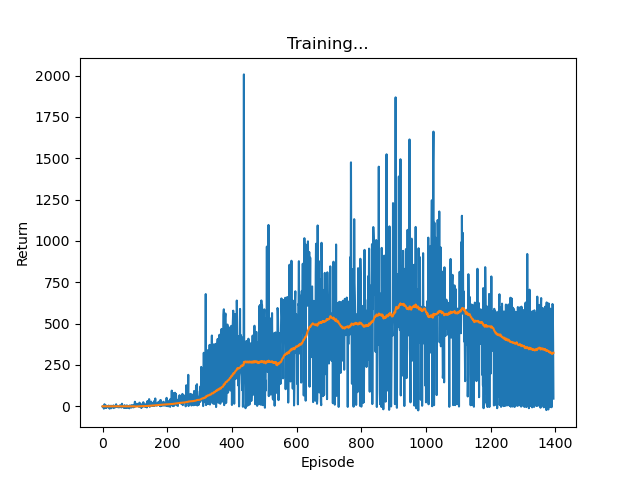

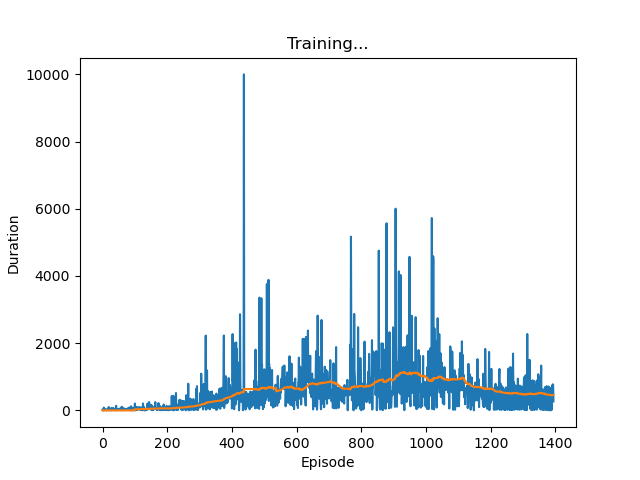

In [6]:
dqn_tracker.plot_returns(returns, show_result=False)
dqn_tracker.plot_durations(durations, show_result=False)

NameError: name 'eps' is not defined

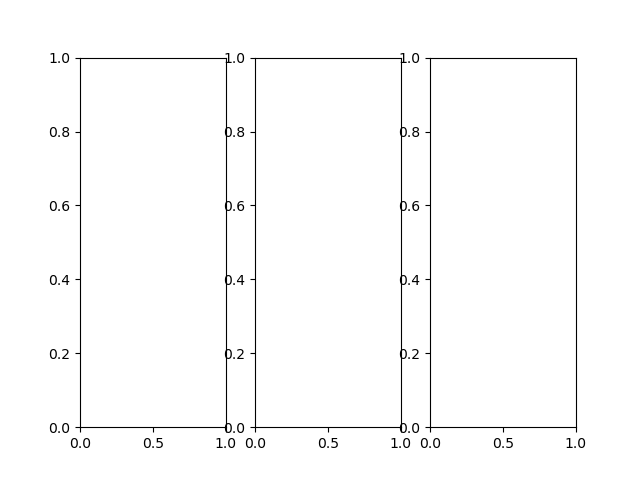

In [7]:
fig, ax = plt.subplots(1,3)
ax[0].plot(eps)
ax[0].set_title("epsilon")
ax[1].plot(lr, label="lr")
ax[1].set_title("learning rate")
ax[2].plot(loss, label="loss")
ax[2].set_title("loss")

In [7]:
fname = '/home/brysongray/tractography/outputs_test/bundle_density_ep1.pt'
density = torch.load(fname)
print(density.shape)

torch.Size([34, 494, 696])


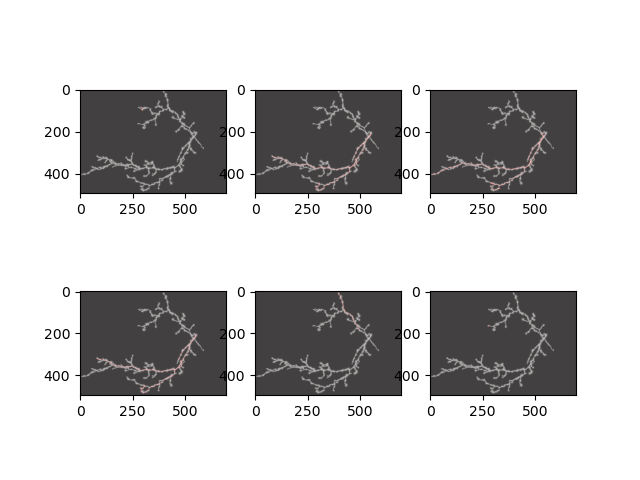

In [9]:
plt.close('all')
fig, ax = plt.subplots(2,3)
for r in range(2):
    for c in range(3):
        i = (r+1)*(c+1)
        if i == 7:
            break
        fname = f'/home/brysongray/tractography/outputs_test/bundle_density_ep{i-1}.pt'
        density = torch.load(fname)
        D = density.amax(dim=0)
        I = env.img.data[:3].amax(dim=(1))
        T = env.true_density.data.amax(dim=(0,1))
        ax[r][c].imshow(D, cmap='hot', alpha=0.5)
        # ax[r][c].imshow(I.permute(1,2,0), alpha=0.5)
        # ax[r][c].imshow(B, cmap='gray', alpha=0.5)
        ax[r][c].imshow(T, cmap='gray', alpha=0.5)

# plt.imshow(T, cmap='gray', alpha=0.5)


# Inference

In [36]:
f = open('/home/brysongray/tractography/neuron_trx/configs/config.json')
args = json.load(f)

img_file = args["image"]
label_file = args["label"]
seeds = args["seeds"]
model = args["model"] if "model" in args else None
n_seeds = args["n_seeds"] if "n_seeds" in args else 1
step_size = args["step_size"] if "step_size" in args else 1.0
step_width = args["step_width"] if "step_width" in args else 1.0
batch_size = args["batchsize"] if "batchsize" in args else 128
gamma = args["gamma"] if "gamma" in args else 0.99
eps_start = args["eps_start"] if "eps_start" in args else 0.9
eps_end = args["eps_end"] if "eps_end" in args else 0.01
eps_decay = args["eps_decay"] if "eps_decay" in args else 1000
tau = args["tau"] if "tau" in args else 0.001
lr = args["lr"] if "lr" in args else 5e-4
alpha = args["alpha"] if "alpha" in args else 1.0
beta = args["beta"] if "beta" in args else 1e-3
friction = args["friction"] if "friction" in args else 1e-4
num_episodes = args["num_episodes"] if "num_episodes" in args else 100
pixelsize = args["pixelsize"] if "pixelsize" in args else [1.0, 1.0, 1.0]
patch_radius = 17
actions = np.load('/home/brysongray/tractography/neuron_trx/action_space_30_dir.npy')

img, density, mask = load_data(img_file, label_file, pixelsize=pixelsize, inverse=True)

env = Environment(img,
                patch_radius,
                seeds,
                mask,
                density,
                actions,
                n_seeds=n_seeds,
                step_size=step_size,
                step_width=step_width,
                max_len=10000,
                alpha=alpha,
                beta=beta,
                friction=friction)

model = DQNModel(in_channels=4,
                    n_actions=len(actions),
                    input_size=(2*patch_radius+1),
                    lr=lr,
                    step_size=torch.tensor(step_size))

params = torch.load("/home/brysongray/tractography/outputs/model_state_dict_alpha-2.0_b-0.5_f-0.2_n-1.pt")

model.load_model(params)



/home/brysongray/tractography/data/Cerebellar Climbing Fibers/Gold Standard Reconstructions/CF_1.swc:1506:warning

/home/brysongray/tractography/data/Cerebellar Climbing Fibers/Gold Standard Reconstructions/CF_1.swc:1493:warning

/home/brysongray/tractography/data/Cerebellar Climbing Fibers/Gold Standard Reconstructions/CF_1.swc:1322:warning

/home/brysongray/tractography/data/Cerebellar Climbing Fibers/Gold Standard Reconstructions/CF_1.swc:1216:warning

/home/brysongray/tractography/data/Cerebellar Climbing Fibers/Gold Standard Reconstructions/CF_1.swc:1118:warning

/home/brysongray/tractography/data/Cerebellar Climbing Fibers/Gold Standard Reconstructions/CF_1.swc:0:warning


In [62]:
count = 0
for key in params:
    count += params[key].numel()
print(count)

8475873


In [ ]:
env.reset()

In [13]:
# seeds = [[25,382,380]]
env.seeds = test_seeds
# env = model.inference(env)

In [15]:
I = []
B = []
T = []
for s in range(len(env.seeds)):
    env = model.inference(env)
    I.append(np.array(env.img.data.to('cpu')))
    T.append(np.array(env.true_density.data.to('cpu')))
    B.append(np.array(env.bundle_density.data.to('cpu')))

In [28]:
plt.close('all')

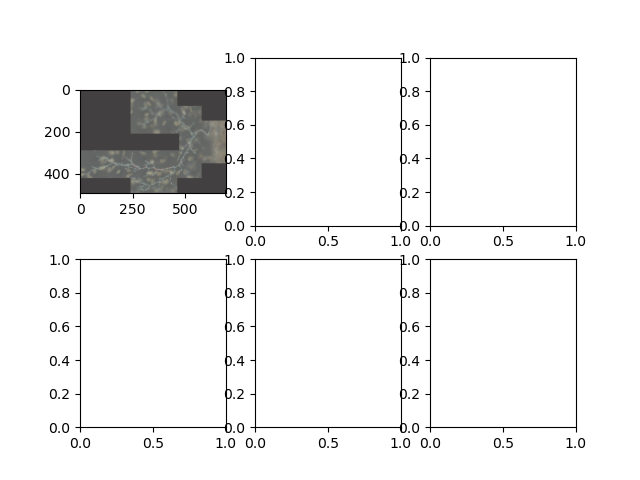

In [32]:
z=23
fig, ax = plt.subplots(2,3)
for i in range(6):
    Ii = I[i][:,z] #.max(axis=1)
    # Ti = T[i][0].max(axis=0)
    # Bi = B[i][0].max(axis=0)
    j = i//3
    k = i%3
    ax[j][k].imshow(Ii[-1], cmap='hot', alpha=0.5) #, int(paths[env.head_id][-1, 0])])
    ax[j][k].imshow(Ii[:3].transpose(1,2,0), alpha=0.5)
    # ax[j][k].imshow(Bi, cmap='hot', alpha=0.5)
    # ax[j][k].imshow(Ti, cmap='gray', alpha=0.5)
    plt.show()


## Compare models

In [6]:
dir = "/home/brysongray/tractography/outputs"
outputs = os.listdir(dir)

returns_files = [o for o in outputs if "returns" in o]
durations_files = [o for o in outputs if "durations" in o]
mae_files = [o for o in outputs if "matching" in o]
friction_files = [o for o in outputs if "friction" in o]
bending_energy_files = [o for o in outputs if "bending_energy" in o]
bending_energy_files.sort()
friction_files.sort()
mae_files.sort()
returns_files.sort()
durations_files.sort()

returns = []
durations = []
maes = []
frictions = []
bending_energies = []
for i in range(len(returns_files)):
    returns.append(torch.tensor(torch.load(os.path.join(dir,returns_files[i]))))
    durations.append(torch.tensor(torch.load(os.path.join(dir,durations_files[i]))))
    maes.append(torch.tensor(torch.load(os.path.join(dir, mae_files[i]))))
    frictions.append(torch.tensor(torch.load(os.path.join(dir, friction_files[i]))))
    bending_energies.append(torch.tensor(torch.load(os.path.join(dir, bending_energy_files[i]))))


In [7]:
Z = np.zeros(len(maes))
for i,m in enumerate(maes):
    Z[i]= m.min().item()



In [8]:
print(np.argmin(Z))
print(returns_files[np.argmin(Z)])
print(min(Z))

25
episode_returns_alpha-2.0_b-0.5_f-0.2_n-1.pt
0.007646201644092798


In [9]:
i = np.argmin(Z)
ep_returns = returns[i]
ep_durations = durations[i]
mae = maes[i]
friction = frictions[i]
bending_energy = bending_energies[i]

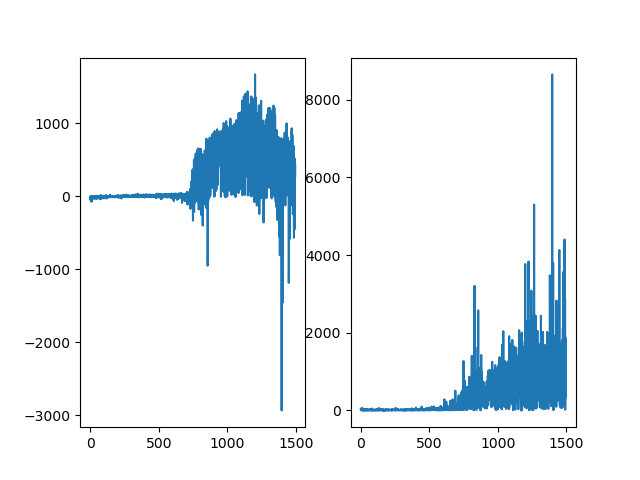

In [10]:
fig, ax = plt.subplots(1,2)
ax[0].plot(ep_returns.numpy())
ax[1].plot(ep_durations.numpy())

In [ ]:
friction.shape

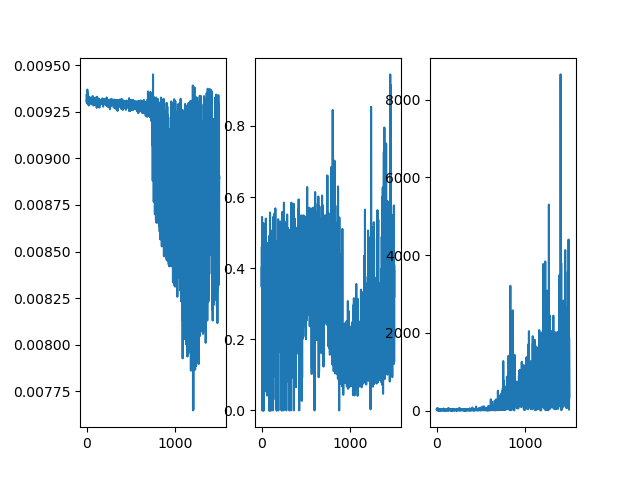

In [11]:
fig, ax = plt.subplots(1,3)
ax[0].plot(mae)
ax[1].plot(bending_energy / friction)
ax[2].plot(friction)